# NBA Lineup Optimization

Here we experiment with optimizing an nba lineup in a few stages:

1. Project player boxscore stats with an estimate of uncertainty

2. Select a collection of players that optimizes probability of winning, given the opponent's player selection, projected player stats (including estimates for prediction uncertainty)

Assumptions:
- For simplicity, we assume that we have perfect knowledge of whether or not a player will play in a game. We can later update this analysis removing this assumption e.g. by creating a model to predict whether or not a player will play in a given game

Issues:
- Errors are correlated across categories e.g. if a player score a lot of 3pts, their fgm and pts will be high
    - Covariance between categories does not matter for expected number of categories won. However, affects probability of winning more categories than opponent.
- Errors are correlated between players e.g. if a player has an increased usage rate and makes a lot of fgs, their teammate likely has fewer fgs as a result of a lower usage rate
- Errors are correlated between observations since since each player has multiple observations
- Opponent lineup includes signal not captured in model. Therefore, in practice, errors for opponent lineup will be biased, overstating probability of winning.

In [1]:
import os
import sys
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
from dotenv import load_dotenv
from scipy.stats import norm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from itertools import combinations
from tqdm import tqdm
from math import comb

In [2]:
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)  # temporary solution until module is installable
    
from lineup import test_expected_categories_won, expected_categories_won

In [3]:
load_dotenv();

## Load data

Data loaded using [basketballreference.com scraper](https://github.com/kevinmchan/nba-scrapy).

In [4]:
DB_URL = os.path.expanduser(os.environ["DB_URL"])
conn = sqlite3.connect(DB_URL)

In [5]:
basic_boxscores = pd.read_sql("select * from basic_boxscore", con=conn)

In [6]:
games = pd.read_sql("select * from games", conn)

## Feature generation

Basic stats to make an illustrative model:
- last 3, 9, 27, 81, 243 game averages
- total games played
- total games played in season

In [7]:
index_cols = ["player_link", "boxscore_link"]
stats = ["fg", "fga", "fg_pct", "fg3", "fg3a", "fg3_pct", "ft", "fta", "ft_pct", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pf", "pts", "plus_minus", "minutes"]
targets = ["fg_pct", "fga", "fg3", "ft_pct", "fta", "trb", "ast", "stl", "blk", "pts"]

In [8]:
denormalized = (
    basic_boxscores
    .merge(games, on=["boxscore_link", "team"], suffixes=["", "_team"])
    .sort_values(by=["player_link", "boxscore_link", "date"])
    .loc[lambda x: x["minutes"] > 0]
    .loc[lambda x: x["playoffs"] == 0]  # TODO: need to fix issues with playoffs flag
)

In [9]:
# rolling average stats
avg_3g, avg_9g, avg_27g, avg_81g, avg_243g = [
     denormalized
    .groupby(["player_link"])[stats]
    .apply(lambda x: x.shift(1).rolling(window=win, min_periods=1).mean())
    .rename(columns=lambda col: f"{col}_{win}g_avg")
    for win in (3, 9, 27, 81, 243)
]
denormalized = reduce(lambda a, b: a.join(b), [denormalized, avg_3g, avg_9g, avg_27g, avg_81g, avg_243g])

In [10]:
# number of games played
denormalized = denormalized.assign(game_rank=lambda y: y.assign(date=lambda x: pd.to_datetime(x["date"])).groupby(["player_link"])["date"].rank())

In [11]:
# number of games played this season
denormalized = denormalized.assign(season_game_rank=lambda y: y.assign(date=lambda x: pd.to_datetime(x["date"])).groupby(["player_link", "season_link"])["date"].rank())

## Model

In [12]:
train_seasons = [f"https://www.basketball-reference.com/leagues/NBA_{year}.html" for year in range(2010, 2017)]
val_seasons = [f"https://www.basketball-reference.com/leagues/NBA_{year}.html" for year in (2017,)]
test_seasons = [f"https://www.basketball-reference.com/leagues/NBA_{year}.html" for year in (2018, 2019)]

In [13]:
features = [
    f"{stat}_{win}g_avg"
    for stat in stats
    for win in (3, 9, 27, 81, 243)
]
features = features + ["game_rank", "season_game_rank"]

In [14]:
train, val, test = (
    denormalized.loc[lambda x: x["season_link"].isin(train_seasons)].copy(),
    denormalized.loc[lambda x: x["season_link"].isin(val_seasons)].copy(),
    denormalized.loc[lambda x: x["season_link"].isin(test_seasons)].copy(),
)

In [15]:
def fit_model(train, val, features, target):
    train_pool = Pool(train.loc[lambda x: x[target].notna(), features], train.loc[lambda x: x[target].notna(), target])
    val_pool = Pool(val.loc[lambda x: x[target].notna(), features], val.loc[lambda x: x[target].notna(), target])
    model = CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSEWithUncertainty', posterior_sampling=True, verbose=False, random_seed=0)
    print("Fitting model for: " + target)
    model.fit(train_pool, eval_set=val_pool)
    print(f"{target} best iteration = {model.get_best_iteration()}")
    return model

models = {
    target: fit_model(train, val, features, target)
    for target in targets
}

Fitting model for: fg_pct
fg_pct best iteration = 199
Fitting model for: fga
fga best iteration = 429
Fitting model for: fg3
fg3 best iteration = 81
Fitting model for: ft_pct
ft_pct best iteration = 89
Fitting model for: fta
fta best iteration = 277
Fitting model for: trb
trb best iteration = 436
Fitting model for: ast
ast best iteration = 322
Fitting model for: stl
stl best iteration = 174
Fitting model for: blk
blk best iteration = 115
Fitting model for: pts
pts best iteration = 260


### Score test population

In [16]:
test_pool = Pool(test[features])
for target, model in models.items():
    test_prediction = model.virtual_ensembles_predict(test_pool, prediction_type='TotalUncertainty', virtual_ensembles_count=30)
    test[f"{target}_prediction"] = test_prediction[:,0]
    test[f"{target}_knowledge_uncertainty"] = test_prediction[:,1]
    test[f"{target}_data_uncertainty"] = test_prediction[:,2]
    test[f"{target}_uncertainty"] = test_prediction[:,1] + test_prediction[:,2]
    test[f"{target}_error"] = test_prediction[:,0] - test[target]
    test[f"{target}_abs_error"] = np.abs(test_prediction[:,0] - test[target])

### Distribution of model error

In [17]:
test[["pts", "pts_prediction", "pts_error", "pts_abs_error", "pts_data_uncertainty", "pts_knowledge_uncertainty"]].describe()

,pts,pts_prediction,pts_error,pts_abs_error,pts_data_uncertainty,pts_knowledge_uncertainty
count,52193.000000,52193.000000,52193.000000,52193.000000,52193.000000,52193.000000
mean,10.253348,9.955170,-0.298178,4.400677,32.124809,0.002673
std,8.202984,5.760252,5.742262,3.700832,15.106655,0.007741
min,0.000000,1.442544,-38.829187,0.000102,4.828574,0.000010
25%,4.000000,5.507818,-3.564971,1.736304,20.719193,0.000290
50%,9.000000,8.736304,0.393249,3.492861,30.082218,0.000791
75%,15.000000,13.134903,3.432135,6.079855,40.921102,0.002198
max,61.000000,31.146529,25.076057,38.829187,140.757285,0.505579


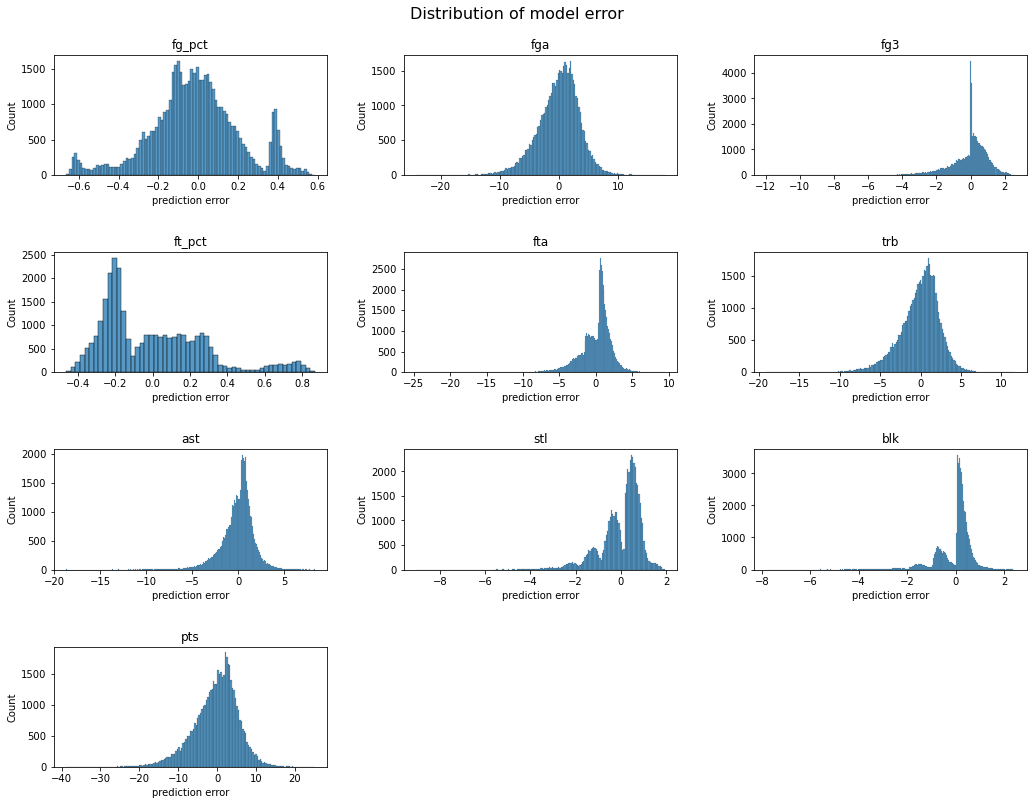

In [18]:
n_plots = len(models)
rows = (n_plots - 1) // 3 + 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(15, 12))
for i in range(n_plots, rows * cols):
    ax[i//3, i%3].set_visible(False)  # hide unused subplots

for i, target in enumerate(models.keys()):
    sns.histplot(data=test.loc[lambda x: x[target].notna()], x=f"{target}_error", ax=ax[i//3, i%3])
    ax[i//3, i%3].set(xlabel="prediction error", title=target)
fig.suptitle('Distribution of model error', fontsize=16, y=0.95)
fig.tight_layout(pad=3.0)

### Distribution of uncertainty

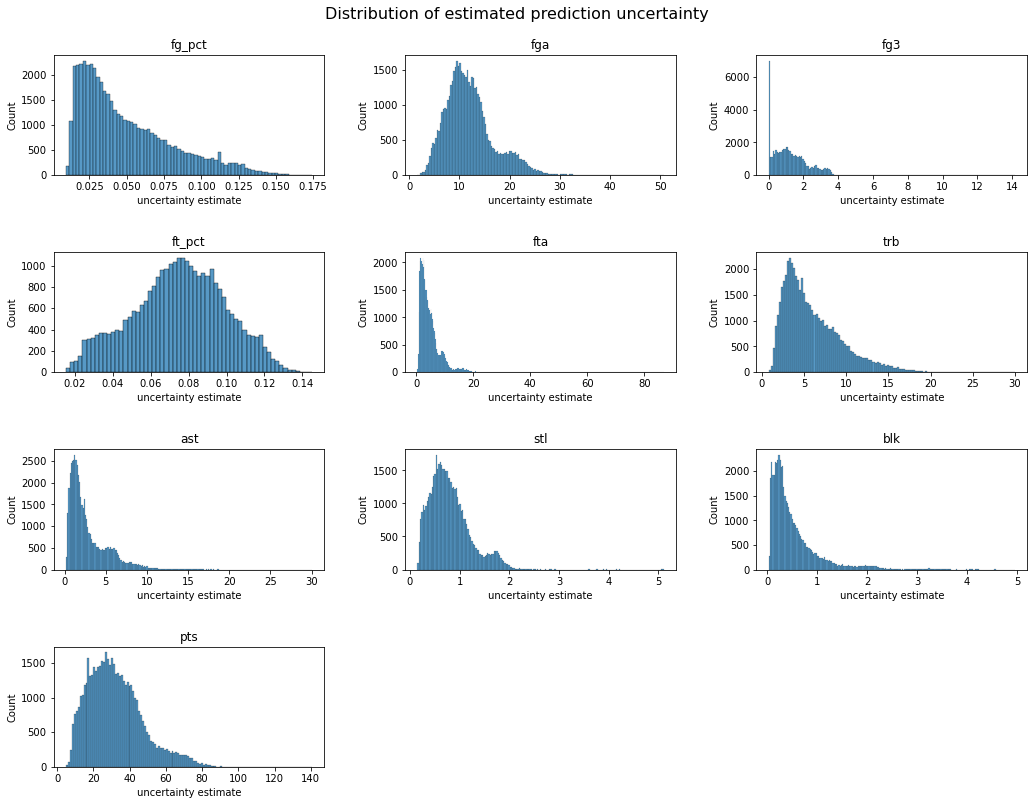

In [19]:
n_plots = len(models)
rows = (n_plots - 1) // 3 + 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(15, 12))
for i in range(n_plots, rows * cols):
    ax[i//3, i%3].set_visible(False)  # hide unused subplots

for i, target in enumerate(models.keys()):
    sns.histplot(data=test.loc[lambda x: x[target].notna()], x=f"{target}_uncertainty", ax=ax[i//3, i%3])
    ax[i//3, i%3].set(xlabel="uncertainty estimate", title=target)
fig.suptitle('Distribution of estimated prediction uncertainty', fontsize=16, y=0.95)
fig.tight_layout(pad=3.0)

### Uncertainty estimate calibration

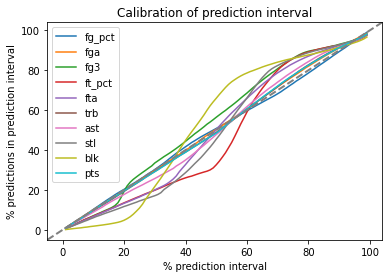

In [20]:
alpha = np.arange(0.01, 1, 0.01)
percent = 1 - alpha
zs = norm.ppf(1 - alpha/2)

for target in models.keys():
    percent_in_pi = np.array([
        test.loc[lambda x: x[target].notna()].pipe(lambda x: x[f"{target}_abs_error"].le(z * np.sqrt(x[f"{target}_uncertainty"])).mean())
        for z in zs
    ])
    ax = sns.lineplot(x=percent * 100, y=percent_in_pi * 100, label=target)
ax.set(xlabel='% prediction interval', ylabel='% predictions in prediction interval', title="Calibration of prediction interval");
ax.axline((0,0), slope=1, linewidth=2, color='grey', linestyle="--");

### Independence of errors between categories

In [21]:
test[[f"{target}_error" for target in targets]].corr().style.background_gradient()

,fg_pct_error,fga_error,fg3_error,ft_pct_error,fta_error,trb_error,ast_error,stl_error,blk_error,pts_error
fg_pct_error,1.000000,0.108769,0.312003,-0.005892,0.064457,0.060391,0.048253,0.046152,0.035852,0.504113
fga_error,0.108769,1.000000,0.412409,0.029263,0.207088,0.373115,0.191018,0.170715,0.115373,0.749487
fg3_error,0.312003,0.412409,1.000000,0.016918,0.062972,0.110721,0.089020,0.067389,0.045965,0.623507
ft_pct_error,-0.005892,0.029263,0.016918,1.000000,0.034499,0.011081,0.018606,0.016857,0.007503,0.136352
fta_error,0.064457,0.207088,0.062972,0.034499,1.000000,0.196524,0.087666,0.084906,0.063786,0.458006
trb_error,0.060391,0.373115,0.110721,0.011081,0.196524,1.000000,0.191411,0.091002,0.150412,0.310034
ast_error,0.048253,0.191018,0.089020,0.018606,0.087666,0.191411,1.000000,0.115163,0.055205,0.166526
stl_error,0.046152,0.170715,0.067389,0.016857,0.084906,0.091002,0.115163,1.000000,0.045429,0.151187
blk_error,0.035852,0.115373,0.045965,0.007503,0.063786,0.150412,0.055205,0.045429,1.000000,0.106491
pts_error,0.504113,0.749487,0.623507,0.136352,0.458006,0.310034,0.166526,0.151187,0.106491,1.000000


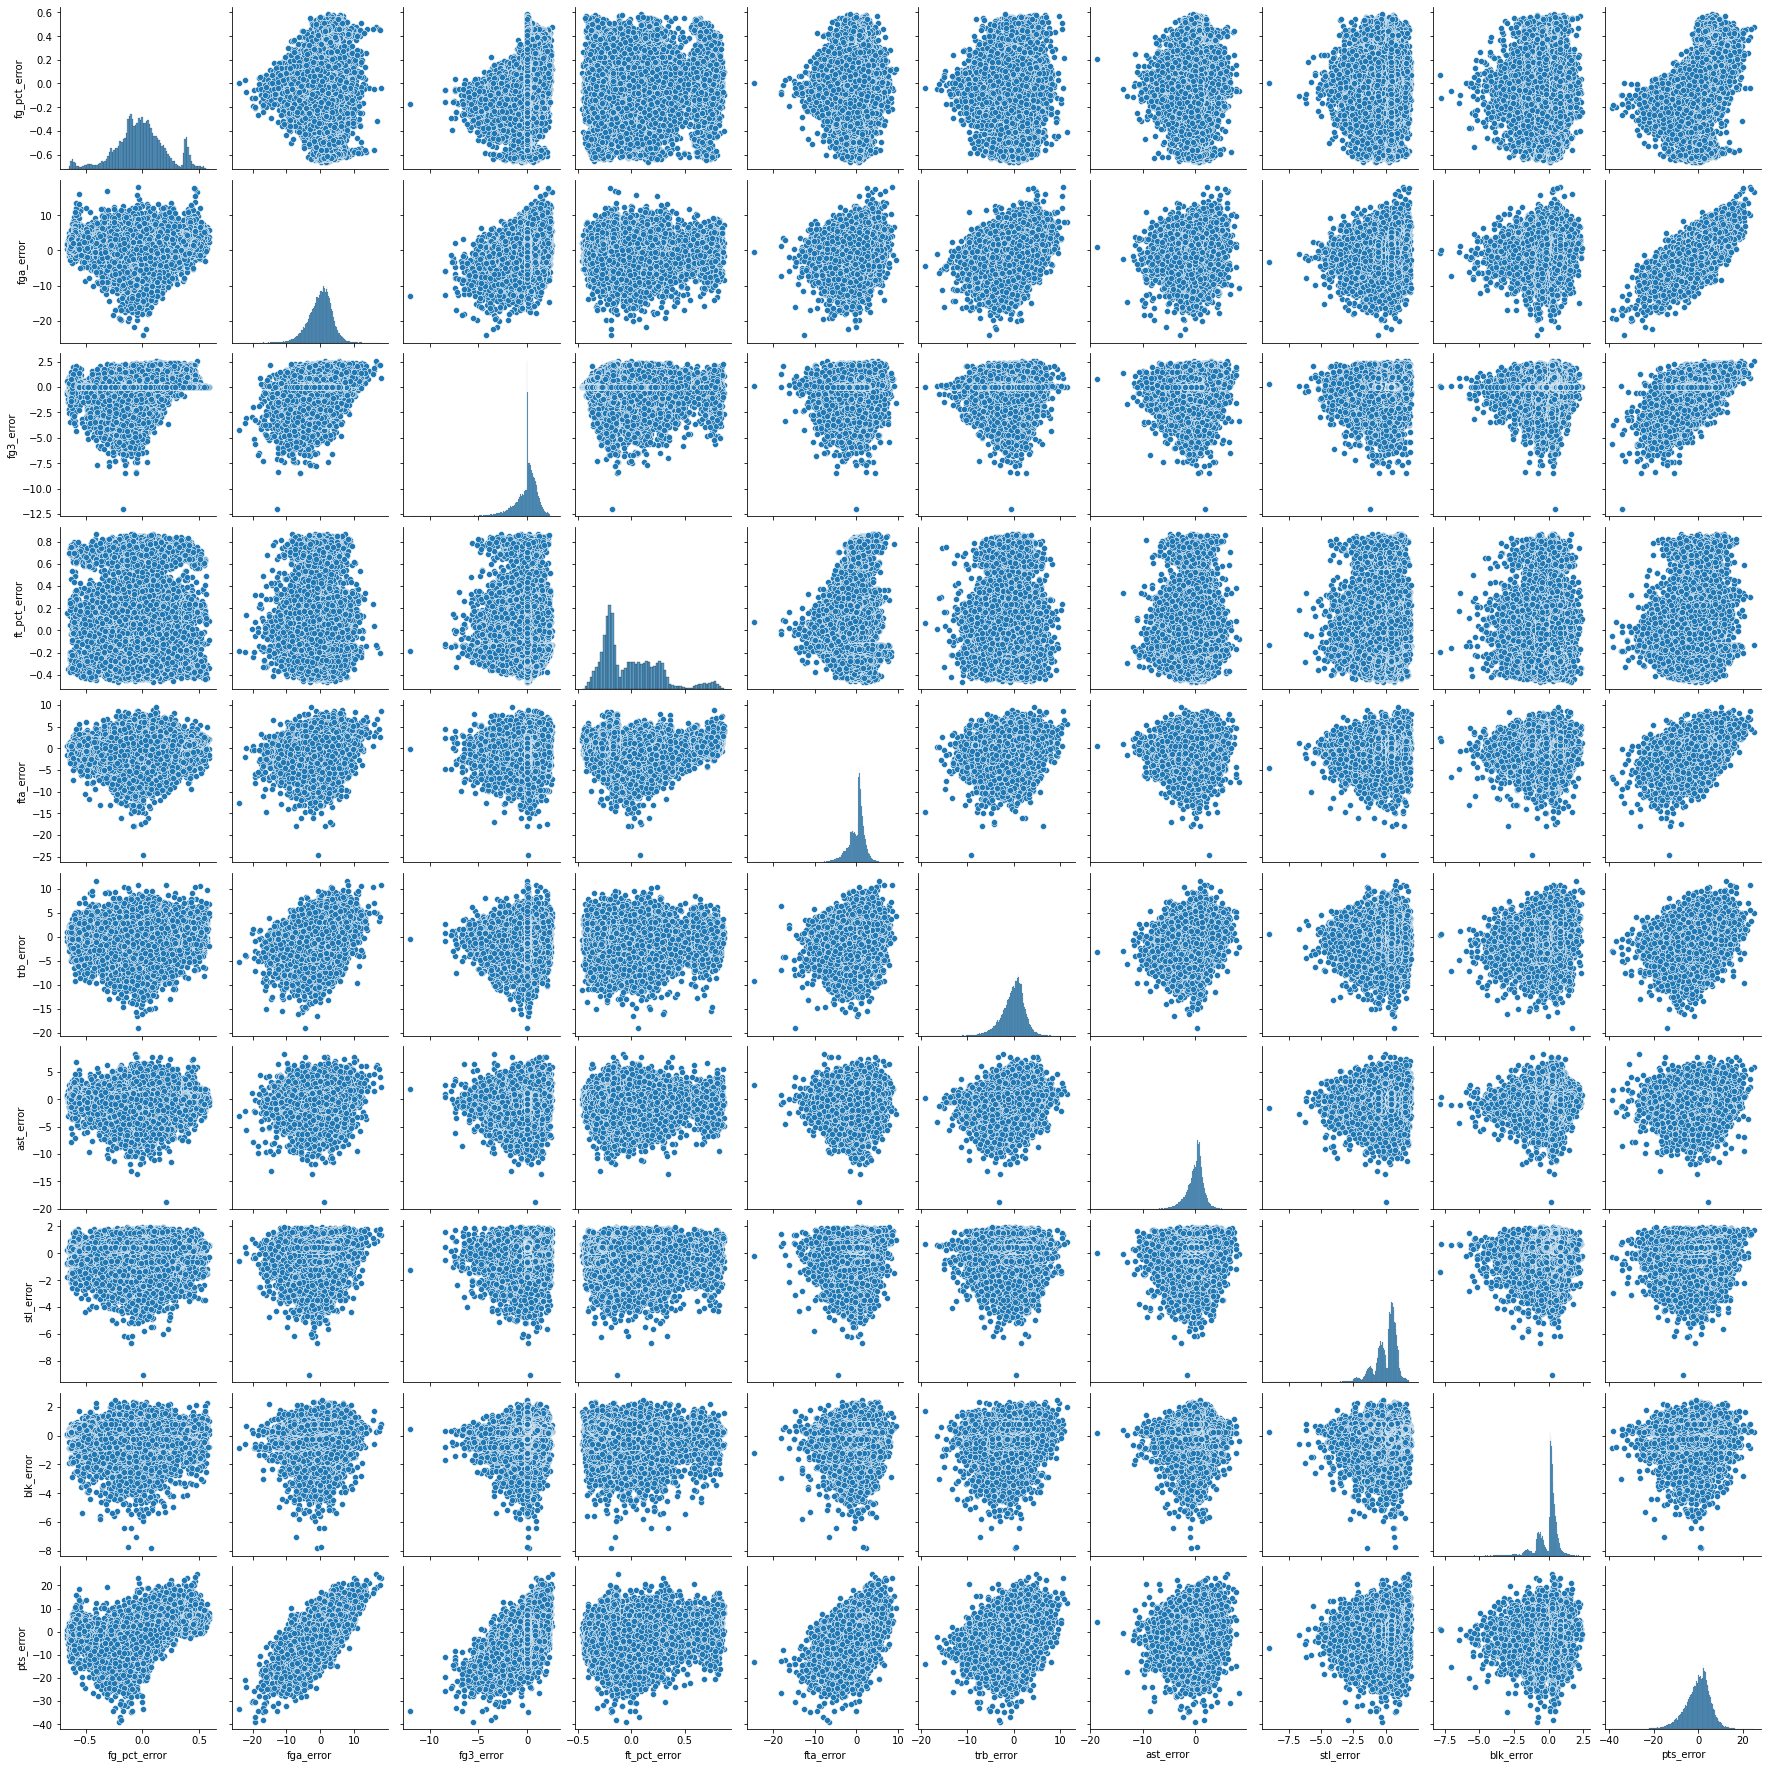

In [22]:
sns.pairplot(test[[f"{target}_error" for target in targets]])

## Estimating expected number of categories won

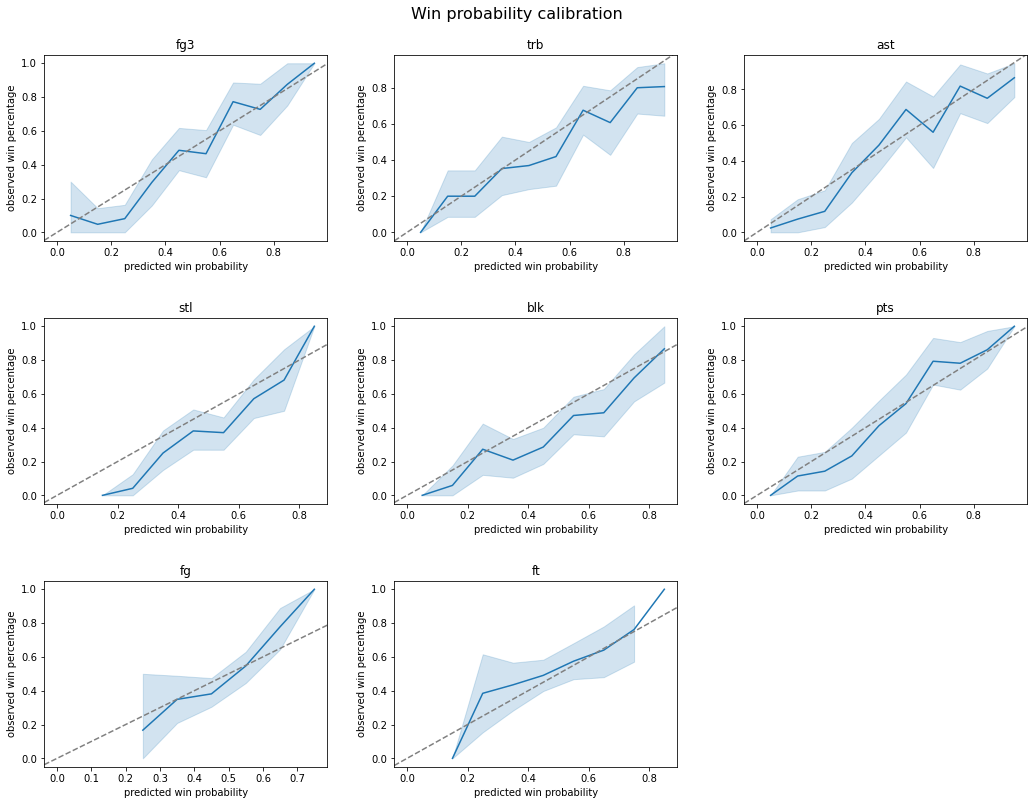

In [25]:
sum_targets=['fg3', 'trb', 'ast', 'stl', 'blk', 'pts']
eff_targets=['fg', 'ft']
targets = sum_targets + eff_targets
result = test_expected_categories_won(test, sum_targets, eff_targets)

n_plots = len(targets)
rows = (n_plots - 1) // 3 + 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(15, 12))

for i in range(n_plots, rows * cols):
    ax[i//3, i%3].set_visible(False)  # hide unused subplots    

bins = np.arange(0, 1.1, 0.1)
for i, col in enumerate(targets):
    sns.lineplot(
        data=(
            result
            .assign(predicted=lambda x: (pd.cut(x[f"{col}_predicted"], bins=bins, labels=False) + 0.5) / 10)
            .sort_values(by=["predicted"])
        ),
        x="predicted",
        y=f"{col}_actual",
        ax=ax[i//3, i%3],
    )
    ax[i//3, i%3].axline((0,0), slope=1, color="grey", linestyle="--")
    ax[i//3, i%3].set(ylabel="observed win percentage", xlabel="predicted win probability", title=col)
fig.suptitle('Win probability calibration', fontsize=16, y=0.95)
fig.tight_layout(pad=3.0)

## Selecting the optimal lineup

In [26]:
lineups = []
n_candidates = 15
candidates_df = test.loc[lambda x: x["date"]=="2017-10-19 00:00:00"].sample(n_candidates)
opp_lineup_df = candidates_df.sample(10)

sum_targets=['fg3', 'trb', 'ast', 'stl', 'blk', 'pts']
eff_targets=['fg', 'ft']

for comb in tqdm(combinations(range(n_candidates), 10), total=comb(n_candidates,10)):
    result = expected_categories_won(
        candidates_df.iloc[list(comb)],
        opp_lineup_df,
        sum_targets=sum_targets,
        eff_targets=eff_targets,
    )
    lineups.append((comb, np.sum(result)))

lineups = sorted(lineups, key=lambda x: x[1] * -1)    

100%|██████████| 3003/3003 [00:26<00:00, 114.45it/s]


In [27]:
# best lineup
best_lineup = list(lineups[0][0])
candidates_df.iloc[best_lineup]

,player,player_link,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,...,blk_data_uncertainty,blk_uncertainty,blk_error,blk_abs_error,pts_prediction,pts_knowledge_uncertainty,pts_data_uncertainty,pts_uncertainty,pts_error,pts_abs_error
471646,Quincy Pondexter,https://www.basketball-reference.com/players/p...,11:55,4.0,6.0,0.667,0.0,1.0,0.000,0.0,...,0.301719,0.301720,0.306388,0.306388,6.911949,0.001612,29.947891,29.949503,-1.088051,1.088051
471700,Montrezl Harrell,https://www.basketball-reference.com/players/h...,3:17,2.0,3.0,0.667,0.0,0.0,NaN,0.0,...,0.815302,0.815319,0.690442,0.690442,7.384805,0.006909,26.667333,26.674242,3.384805,3.384805
471680,Andre Roberson,https://www.basketball-reference.com/players/r...,20:58,3.0,7.0,0.429,0.0,2.0,0.000,0.0,...,0.988412,0.988416,0.857942,0.857942,4.901553,0.002666,16.310186,16.312852,-1.098447,1.098447
471690,Danilo Gallinari,https://www.basketball-reference.com/players/g...,33:03,3.0,13.0,0.231,2.0,6.0,0.333,3.0,...,0.301197,0.301203,-0.703419,0.703419,18.257842,0.008572,55.653767,55.662339,7.257842,7.257842
471697,Willie Reed,https://www.basketball-reference.com/players/r...,13:03,3.0,6.0,0.500,0.0,0.0,NaN,2.0,...,0.915858,0.915880,0.696554,0.696554,3.758145,0.000876,15.538583,15.539458,-4.241855,4.241855
471652,Jonas Valančiūnas,https://www.basketball-reference.com/players/v...,30:30,9.0,17.0,0.529,0.0,1.0,0.000,5.0,...,0.972156,0.972158,0.841345,0.841345,10.228394,0.006568,35.582772,35.589340,-12.771606,12.771606
471654,Serge Ibaka,https://www.basketball-reference.com/players/i...,24:14,3.0,8.0,0.375,2.0,4.0,0.500,0.0,...,1.922661,1.922665,-0.705835,0.705835,12.218860,0.005617,39.498328,39.503945,4.218860,4.218860
471713,Tyler Ennis,https://www.basketball-reference.com/players/e...,9:50,1.0,3.0,0.333,0.0,0.0,NaN,0.0,...,0.082942,0.082945,0.112411,0.112411,7.494026,0.045569,34.486302,34.531871,5.494026,5.494026
471671,Lance Thomas,https://www.basketball-reference.com/players/t...,15:30,1.0,4.0,0.250,0.0,2.0,0.000,0.0,...,0.170066,0.170067,0.181204,0.181204,6.349179,0.006405,28.025638,28.032043,4.349179,4.349179
471677,Carmelo Anthony,https://www.basketball-reference.com/players/a...,33:41,8.0,20.0,0.400,3.0,10.0,0.300,3.0,...,0.516481,0.516489,-1.513266,1.513266,19.013230,0.021024,62.227472,62.248496,-2.986770,2.986770
